# Library

In [1]:
%matplotlib inline
from sklearn import neural_network
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Global

In [2]:
predict = dict()

# Data preprocess

In [3]:
date_feature = pd.read_csv("../data/date_feature.csv", parse_dates=True).fillna(value=0)

In [4]:
date_feature.datetime.head()

0    2016/1/1 0:00
1    2016/1/1 1:00
2    2016/1/1 2:00
3    2016/1/1 3:00
4    2016/1/1 4:00
Name: datetime, dtype: object

In [5]:
date_feature[date_feature.datetime == "2016/6/1 0:00"]

,datetime,AMB_TEMP,PM2.5,RAINFALL,RH,WIND_SPEED,WS_HR,origin_PM2.5,weekday,weekend,...,hour_19,hour_20,hour_21,hour_22,hour_23,fall,spring,summer,winter,dlt_PM2.5
3648,2016/6/1 0:00,0.71831,0.037594,0.0,0.848837,0.285714,0.333333,11.0,1,0,...,0,0,0,0,0,0,0,1,0,-0.007519


In [6]:
train_start, train_size = 3648, 24*28
train = date_feature[train_start:train_start + train_size]
test = date_feature[train_start + train_size:train_start +  train_size + 48]

In [7]:
exclude = ['datetime', 'PM2.5', 'PM10', 'WIND_DIREC', 'WD_HR', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'SO2', 'origin_PM2.5', 'dlt_PM2.5']
features = [f for f in date_feature.columns if f not in exclude]

In [8]:
print features

['AMB_TEMP', 'RAINFALL', 'RH', 'WIND_SPEED', 'WS_HR', 'weekday', 'weekend', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'fall', 'spring', 'summer', 'winter']


In [9]:
target = "PM2.5"

In [10]:
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Regression Tree

In [11]:
RT = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5))
RT.fit(X_train, y_train)
print 'Importances: \n', RT.feature_importances_

Importances: 
[  7.87767145e-02   4.62805412e-04   2.91816032e-01   1.02437742e-01
   8.08447942e-02   2.36458412e-02   4.00992086e-02   6.92627912e-04
   4.33486134e-04   4.07263967e-04   2.07399575e-03   4.50050841e-04
   3.06608343e-03   1.13707447e-02   6.22754293e-03   2.13706606e-03
   7.22579121e-04   8.28405626e-04   1.45670213e-03   3.87076544e-04
   2.85881729e-04   0.00000000e+00   1.50772771e-04   3.50454667e-04
   1.88843522e-02   1.89193013e-02   1.29513246e-02   5.98400012e-02
   1.03254355e-01   1.03646131e-01   3.33806625e-02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]


In [13]:
predict["RT"] = RT.predict(X_test)

# Linear Regression

In [14]:
LR = linear_model.LinearRegression()
LR.fit(X_train, y_train)
print 'Coefficients: \n', LR.coef_

Coefficients: 
[  1.44914227e-01   2.24756582e-02  -7.62914909e-03  -3.70370446e-02
  -5.50458175e-02   2.83816426e+11   2.83816426e+11   4.40215576e+08
   4.40215576e+08   4.40215576e+08   4.40215576e+08   4.40215576e+08
   4.40215576e+08   4.40215576e+08   4.40215576e+08   4.40215576e+08
   4.40215576e+08   4.40215576e+08   4.40215576e+08   4.40215576e+08
   4.40215576e+08   4.40215576e+08   4.40215576e+08   4.40215576e+08
   4.40215576e+08   4.40215576e+08   4.40215576e+08   4.40215576e+08
   4.40215576e+08   4.40215576e+08   4.40215576e+08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [15]:
predict["LR"] = LR.predict(X_test)

# MLP Regression

In [16]:
MLP = neural_network.MLPRegressor(activation='relu')
MLP.fit(X_train, y_train)
print 'Model: \n', MLP

Model: 
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [17]:
predict["MLP"] = MLP.predict(X_test)

# Plot

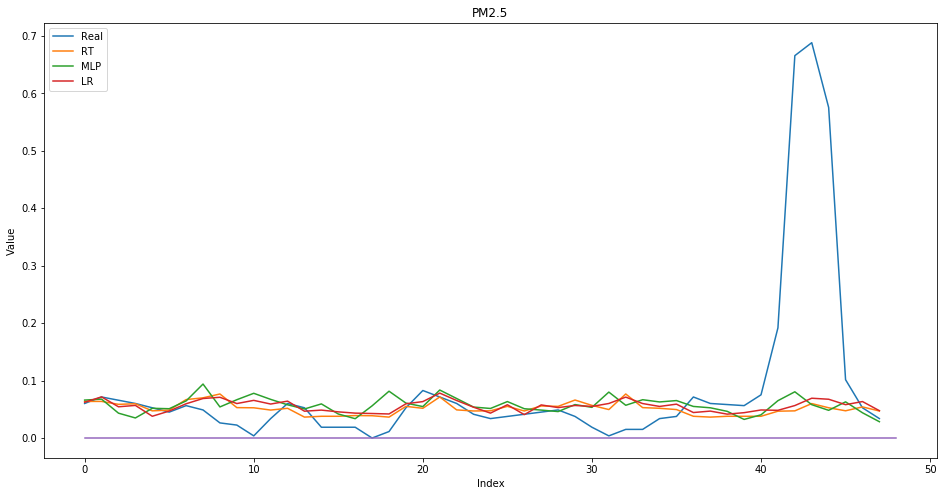

In [19]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
plt.figure()
plt.title(target)
plt.xlabel("Index")
plt.ylabel("Value")
plt.plot(y_test.tolist(), label="Real")

for key, value in predict.iteritems():
    plt.plot(value, label=key)
    
plt.plot([0, len(y_test)], [0, 0])
plt.legend(loc='upper left')
plt.show()

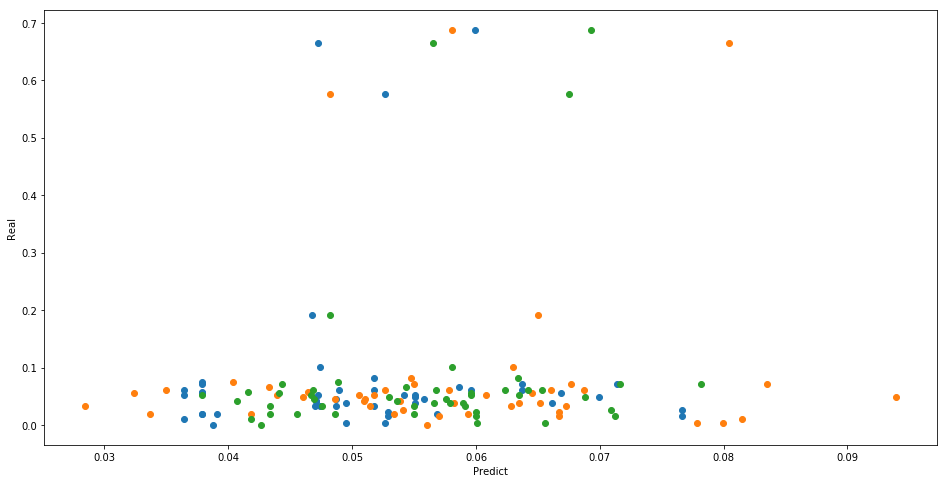

In [26]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
plt.xlabel('Predict')
plt.ylabel('Real')

for key, value in predict.iteritems():
    plt.plot(value, y_test.tolist(), 'o')
    
plt.show()

# Measure

In [31]:
for key, value in predict.iteritems():
    print("'%s' mean squared error: %.6f"
          % (key, mean_squared_error(value, y_test)))

'RT' mean squared error: 0.022912
'MLP' mean squared error: 0.022406
'LR' mean squared error: 0.022125
